In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Created on Tue Mar 14 14:47:58 2023

@author: mariapopovic
"""

from numpy import array, exp, append, linspace, log, average, around, arange, sqrt, random, inf
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from math import erf, pi, erfc
from scipy.special import erfinv
from scipy.stats import norm
from statistics import mean, stdev
from sklearn.metrics import mean_absolute_error

<BarContainer object of 8 artists>

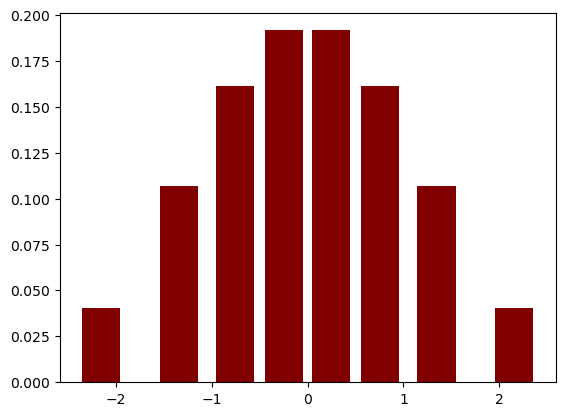

In [3]:
### Load data from files generated with Mathematica ###

n = [2,3,4,5,6,7,8,9,10,11,12]
probabilities_stationary = []
knots_stationary = []
number_bins_list = []
number_bins_str = []

index = 0
for el in n:
    number_bins_list.append(2**int(el))
    number_bins_str.append(str(number_bins_list[index]))
    index = index + 1

for el in number_bins_str:
    prob = []
    gam = []
          
    f1=open("probabilities_NBins_" + el + ".txt", "r")

    if f1.mode == 'r':
        t=f1.readlines()

    for index in t:
        
        prob.append(float(index.replace('\n','')))
       
    f2=open("gammas_NBins_"+el+".txt", "r")

    if f2.mode == 'r':
        g=f2.readlines()

    for index in g:
        gam.append(float(index.replace('\n','')))
      
    
    knots_stationary.append(gam)
    probabilities_stationary.append(prob)

# Plots one example, in this case for 2^3 bins

plt.bar(knots_stationary[1], probabilities_stationary[1], color ='maroon', width=0.4)

    

# Stationary quantizers

In [97]:
### Create stationary quantizers ###

cell_bounds_stationary = []
cdf_stationary_rightbound = []

for index in range(0,len(number_bins_list)):
    
    # Append extreme left bound
    
    cell_bounds_stationary.append([-inf])
    
    for index2 in range(1,len(knots_stationary[index])):
    
        cell_bounds_stationary[index].append((knots_stationary[index][index2] + knots_stationary[index][index2 - 1])/2)
        
    # Append extreme right bound
    
    cell_bounds_stationary[index].append(inf)
    
    # Define the cumulative distribution function from the right extreme of each cell

    cdf_stationary_rightbound.append(norm.cdf(cell_bounds_stationary[index][1:]))

    # Round last element to = 1
    
    tmp = cdf_stationary_rightbound[index][:-1]
    cdf_stationary_rightbound[index] = append(tmp,round(cdf_stationary_rightbound[index][-1]))
    



# Linear quantizers

In [98]:
### Create linear quantizers in equal length intervals with corresponding CDFs ###

# Initiate lists: each elemement will also be a list corresponding to 2^2 number of bins, 2^3, 2^4 etc

knots_linear = []
probabilities_linear = [[]]*len(number_bins_list)
cell_bounds_linear = []
cdf_linear_rightbound = []

def probabilities_equations_linear (g0,g1,g2):
    return 0.5*(erf((g1 + g2)/(2*sqrt(2))) - erf((g0 + g1)/(2*sqrt(2))))

for index in range(0,len(number_bins_list)):
    
    # Create knots for linear quantizers from the gamma functions
    
    kl = linspace(knots_stationary[index][0], knots_stationary[index][-1], number_bins_list[index])
    knots_linear.append(kl)        
    
    cell_bounds_linear.append([-inf])
    
    for index2 in range(1,len(knots_linear[index])):
    
        cell_bounds_linear[index].append((knots_linear[index][index2] + knots_linear[index][index2 - 1])/2)
        
    # Append extreme right bound
    
    cell_bounds_linear[index].append(inf)
    
    # Define the cumulative distribution function from the right extreme of each cell

    cdf_linear_rightbound.append(norm.cdf(cell_bounds_linear[index][1:]))
    
    # Round last element to = 1

    tmp = cdf_linear_rightbound[index][:-1]
    cdf_linear_rightbound[index] = append(tmp,round(cdf_linear_rightbound[index][-1]))
    
    # Build probabilities 
    
    # Append first probability value
    
    mid = int(len(knots_linear[index])/2)
    
    prob_first = probabilities_equations_linear(- knots_linear[index][mid],knots_linear[index][mid], knots_linear[index][mid + 1])
    probabilities_linear[index] = append(probabilities_linear[index], prob_first)
    
    for index2 in range(mid + 1, len(knots_linear[index]) - 1):
        
        prob = probabilities_equations_linear(knots_linear[index][index2-1],knots_linear[index][index2],knots_linear[index][index2+1])
        probabilities_linear[index] = append(probabilities_linear[index], prob)
        
    # Append last probability value
    prob_last = probabilities_equations_linear(knots_linear[index][-2],knots_linear[index][-1],inf)
    probabilities_linear[index] = append(probabilities_linear[index],prob_last)
    
    # Add probabilities for negative values of knots
    probabilities_linear[index] = append(probabilities_linear[index][::-1],probabilities_linear[index])


# Equimass quantizers

In [99]:
### Create equi-mass quantizers ###

probabilities_equimass = [[]]*len(number_bins_list)
knots_equimass = []
cell_bounds_equimass = [[]]*len(number_bins_list)
cdf_equimass_rightbound = []


# Define inverse error function "erf" for calculations

def inverse_cdf(y):
    return sqrt(2)*erfinv(2*y - 1)

# Probabilities for equi-mass quantizer, same for every knot

for index_bin in range(0,len(number_bins_list)):
    
    el = number_bins_list[index_bin];
    probabilities_equimass[index_bin] = append(probabilities_equimass[index_bin], [1/el]*el)
    
# Create knots for equi-mass quantizer

for n in number_bins_list:
    
    gammas_equimass = []
    
    for i in range(1, n + 1):
        
        num_i = exp(-((inverse_cdf((i-1)/n))**2)/2) - exp(-((inverse_cdf(i/n))**2)/2)
        gamma_i = (n/(sqrt(2*pi)))*(num_i)
        gammas_equimass.append(gamma_i)
     
    knots_equimass.append(gammas_equimass)

    
# Create bounds for cells

for index_bin in range(0,len(number_bins_list)):
    
    n = number_bins_list[index_bin]
       
    for i in range(0, n+1):
        cell_bounds_equimass[index_bin] = append(cell_bounds_equimass[index_bin],inverse_cdf(i/n))

    

# Define the cumulative distribution function from the right extreme of each cell

for index_bin in range(0,len(number_bins_list)):
    cdf_equimass_rightbound.append(norm.cdf(cell_bounds_equimass[index_bin][1:]))
    
# Round last element to = 1

for index_bin in range(0,len(number_bins_list)):
    
    tmp = cdf_equimass_rightbound[index_bin][:-1]
    cdf_equimass_rightbound[index_bin] = append(tmp,round(cdf_equimass_rightbound[index_bin][-1]))
    

#  Random variable from normal distribution value

In [100]:
### Normal distribution values for stockprice process at expiry date ###

int_rate = 0.05 # Interest rate
K = 0.5 # Strike
sigma = 0.2 # Volatility
s_0 = 1 # Spot
T = 0.25 # Expiry date
        
def stockprice_process(y):

    s_T = s_0*exp((int_rate - 0.5*(sigma**2))*T + sigma*sqrt(T)*y)
        
    return s_T

# The real value of S_T is given for y = Wt defined by a Brownian motion, i.e, normal distribution


blackscholes_theoretical_iterations = []
iterations = 4000000

ct = 1

while ct <= iterations:
    wt = random.normal(0,1)
    sT = stockprice_process(wt)
    blackscholes_theoretical_iterations.append(max(sT-K,0))
    ct = ct + 1
    
blackscholes_theoretical = average(blackscholes_theoretical_iterations)
blackscholes_theoretical_standard_error = stdev(blackscholes_theoretical_iterations)/sqrt(iterations)

#data_value_option_pricing = 0.04673 # for K = 1
#0.5125 for K = 0.5

data_option_pricing = [blackscholes_theoretical]*len(number_bins_list)

# Simulation for linear, stationary and equimass Black-Scholes option pricing

In [101]:
### Simulation of the stockprice process and call option ###

# Initialize counts

count_linear = [0]*len(number_bins_list)
count_stationary = [0]*len(number_bins_list)
count_equimass = [0]*len(number_bins_list)

number_simulations = 600000 # Change to set number of samples per simulation
data_option_pricing_iterations = [blackscholes_theoretical]*number_simulations

# If you only want to calculate the probability distribution from very large number_simulations, set total_counts = 1
total_counts = 1 # Change to set number of repetitions of calculations of average values
data_option_pricing_counts = [blackscholes_theoretical]*total_counts
ct = 1

# Inizialize vectors for storing iterations

stockprice_linear_counts = [[]]*len(number_bins_list)
stockprice_stationary_counts = [[]]*len(number_bins_list)
stockprice_equimass_counts = [[]]*len(number_bins_list)

blackscholes_linear_counts = [[]]*len(number_bins_list)
blackscholes_stationary_counts = [[]]*len(number_bins_list)
blackscholes_equimass_counts = [[]]*len(number_bins_list)

mean_absolute_error_linear_counts = [[]]*len(number_bins_list)
mean_absolute_error_stationary_counts = [[]]*len(number_bins_list)
mean_absolute_error_equimass_counts = [[]]*len(number_bins_list)

standard_deviation_linear_counts = [[]]*len(number_bins_list)
standard_deviation_stationary_counts = [[]]*len(number_bins_list)
standard_deviation_equimass_counts = [[]]*len(number_bins_list)

standard_error_linear_counts = [[]]*len(number_bins_list)
standard_error_stationary_counts = [[]]*len(number_bins_list)
standard_error_equimass_counts = [[]]*len(number_bins_list)

while ct <= total_counts:

    # Initialize stockprice simulations:
    
    # For storing the results of each iteration
    
    stockprice_linear_iterations = [[]]*len(number_bins_list)
    stockprice_stationary_iterations = [[]]*len(number_bins_list)
    stockprice_equimass_iterations = [[]]*len(number_bins_list)
    
    blackscholes_linear_iterations = [[]]*len(number_bins_list)
    blackscholes_stationary_iterations = [[]]*len(number_bins_list)
    blackscholes_equimass_iterations = [[]]*len(number_bins_list)
    
    iterations = 0
    
    while iterations < number_simulations:
        
        u = random.uniform(0,1) # In order to have correlation between quantizers
    
        for index_bins in range(0,len(number_bins_list)):
        

    # Finds the CDF to which domain the random number belongs to and assigns the corresponding quantizer/knot
    # This code corresponds to the operation y = F^(-1) (u) with u random variable in [0,1], 
    # and where F is CDF

            index2 = 0
    
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]

  
            index2 = 0
    
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1

            y_stationary = knots_stationary[index_bins][index2]
        
            index2 = 0
    
            while cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1

            y_equimass = knots_equimass[index_bins][index2]
            
            stockprice_linear_iterations[index_bins] = append(stockprice_linear_iterations[index_bins],stockprice_process(y_linear))
            
            stockprice_stationary_iterations[index_bins] = append(stockprice_stationary_iterations[index_bins],stockprice_process(y_stationary))
           
            stockprice_equimass_iterations[index_bins] = append(stockprice_equimass_iterations[index_bins],stockprice_process(y_equimass))
        
            blackscholes_linear_iterations[index_bins] = append(blackscholes_linear_iterations[index_bins],max(stockprice_process(y_linear)-K,0))
            
            blackscholes_stationary_iterations[index_bins] = append(blackscholes_stationary_iterations[index_bins],max(stockprice_process(y_stationary)-K,0))
            
            blackscholes_equimass_iterations[index_bins] = append(blackscholes_equimass_iterations[index_bins],max(stockprice_process(y_equimass)-K,0))
            
            
        iterations = iterations + 1
        # End of 'while' loop for iterations
        
    # Save value of mean stockprice over all #iterations = number_simulations
                
    for index_bins in range(0,len(number_bins_list)):
        
        mean_linear_stockprice = average(stockprice_linear_iterations[index_bins])
        mean_stationary_stockprice = average(stockprice_stationary_iterations[index_bins])
        mean_equimass_stockprice = average(stockprice_equimass_iterations[index_bins])
    
        stockprice_linear_counts[index_bins] = append(stockprice_linear_counts[index_bins],mean_linear_stockprice)
        stockprice_stationary_counts[index_bins] = append(stockprice_stationary_counts[index_bins],mean_stationary_stockprice)
        stockprice_equimass_counts[index_bins] = append(stockprice_equimass_counts[index_bins],mean_equimass_stockprice)
        
        # Save value of mean blackscholes over all #iterations = number_simulations, in order to compute standard deviation and erros over total_counts
        
        mean_linear_blackscholes = average(blackscholes_linear_iterations[index_bins])
        mean_stationary_blackscholes = average(blackscholes_stationary_iterations[index_bins])
        mean_equimass_blackscholes = average(blackscholes_equimass_iterations[index_bins])
        
        blackscholes_linear_counts[index_bins] = append(blackscholes_linear_counts[index_bins],mean_linear_blackscholes)
        blackscholes_stationary_counts[index_bins] = append(blackscholes_stationary_counts[index_bins],mean_stationary_blackscholes)
        blackscholes_equimass_counts[index_bins] = append(blackscholes_equimass_counts[index_bins],mean_equimass_blackscholes)
        
        # Save value for mean error over the iterations, number_simulations
        
        mean_linear_error = mean_absolute_error(blackscholes_linear_iterations[index_bins],data_option_pricing_iterations)
        mean_stationary_error = mean_absolute_error(blackscholes_stationary_iterations[index_bins],data_option_pricing_iterations)
        mean_equimass_error = mean_absolute_error(blackscholes_equimass_iterations[index_bins],data_option_pricing_iterations)
        
        mean_absolute_error_linear_counts[index_bins]  = append(mean_absolute_error_linear_counts[index_bins],mean_linear_error)
        mean_absolute_error_stationary_counts[index_bins]  = append(mean_absolute_error_stationary_counts[index_bins],mean_stationary_error)
        mean_absolute_error_equimass_counts[index_bins]  = append(mean_absolute_error_equimass_counts[index_bins],mean_equimass_error)
        
        # Save value for standard deviation over the iterations, number_simulations
        
        standard_deviation_linear = stdev(blackscholes_linear_iterations[index_bins])
        standard_deviation_stationary = stdev(blackscholes_stationary_iterations[index_bins])
        standard_deviation_equimass = stdev(blackscholes_equimass_iterations[index_bins])
        
        standard_deviation_linear_counts[index_bins] = append(standard_deviation_linear_counts[index_bins],standard_deviation_linear)
        standard_deviation_stationary_counts[index_bins] = append(standard_deviation_stationary_counts[index_bins],standard_deviation_stationary)
        standard_deviation_equimass_counts[index_bins] = append(standard_deviation_equimass_counts[index_bins],standard_deviation_equimass)
        
        # Save value for standard deviation over the iterations, number_simulations
        
        standard_error_linear_counts[index_bins] = append(standard_error_linear_counts[index_bins],standard_deviation_linear/sqrt(number_simulations))
        standard_error_stationary_counts[index_bins] = append(standard_error_stationary_counts[index_bins],standard_deviation_stationary/sqrt(number_simulations))
        standard_error_equimass_counts[index_bins] = append(standard_error_equimass_counts[index_bins],standard_deviation_equimass/sqrt(number_simulations))

        # Check if the average (S - K)^+ obtained is within 0.01% of the real value: this counts how many times
        # the average value comes within +/- 0.0001 of the real value
    
        if abs(mean_linear_blackscholes - blackscholes_theoretical) <= 0.0001:
            count_linear[index_bins] = count_linear[index_bins] + 1
            
        if abs(mean_stationary_blackscholes - blackscholes_theoretical) <= 0.0001:
            count_stationary[index_bins] = count_stationary[index_bins] + 1
            
        if abs(mean_equimass_blackscholes - blackscholes_theoretical) <= 0.0001:
            count_equimass[index_bins] = count_equimass[index_bins] + 1
    # End of 'for' loop for bins
    
    ct = ct + 1
# End of 'while' loop for counts

# Mean values of the simulations, if repeated simulations

In [102]:
### Averages over number of counts = total_counts ###
# If total_counts > 1

# Initialize mean values lists

stockprice_linear = []
stockprice_stationary = []
stockprice_equimass = []

blackscholes_linear = []
blackscholes_stationary = []
blackscholes_equimass = []

absolute_error_linear = []
absolute_error_stationary = []
absolute_error_equimass= []

for index_bins in range(0,len(number_bins_list)):
    
    stockprice_linear.append(average(stockprice_linear_counts[index_bins]))
    stockprice_stationary.append(average(stockprice_stationary_counts[index_bins]))
    stockprice_equimass.append(average(stockprice_equimass_counts[index_bins]))
    
    blackscholes_linear.append(average(blackscholes_linear_counts[index_bins]))
    blackscholes_stationary.append(average(blackscholes_stationary_counts[index_bins]))
    blackscholes_equimass.append(average(blackscholes_equimass_counts[index_bins]))

# Absolute error
    absolute_error_linear.append(abs(blackscholes_linear[index_bins] - blackscholes_theoretical))
    absolute_error_stationary.append(abs(blackscholes_stationary[index_bins] - blackscholes_theoretical))
    absolute_error_equimass.append(abs(blackscholes_equimass[index_bins]- blackscholes_theoretical))

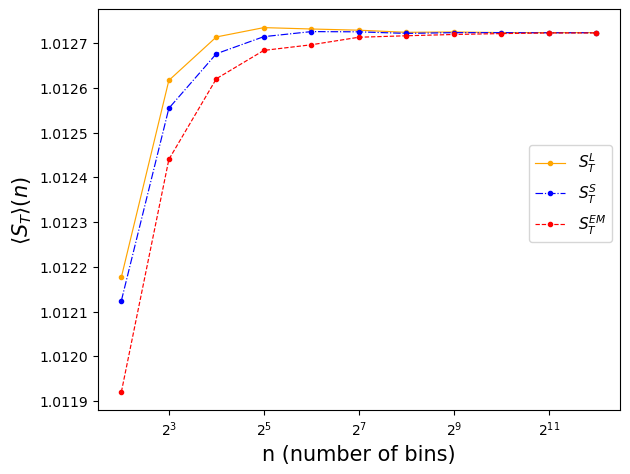

In [32]:
### Plots of average stockprice for all quantizers ###

f1 = plt.figure(1)
ax=plt.axes()

ax.plot(number_bins_list,stockprice_linear,label=r'$S^{L}_T$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax.plot(number_bins_list,stockprice_stationary,label=r'$S^{S}_T$',marker = ".", markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashdot')
ax.plot(number_bins_list,stockprice_equimass,label=r'$S^{EM}_T$',marker = ".", markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')

ax.set_xlabel('n (number of bins)',fontsize=15)
ax.set_ylabel(r'$\langle S_{T} \rangle (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.4),fontsize=11)


plt.show()

# K = 1: mean absolute error, standard deviation, standard error

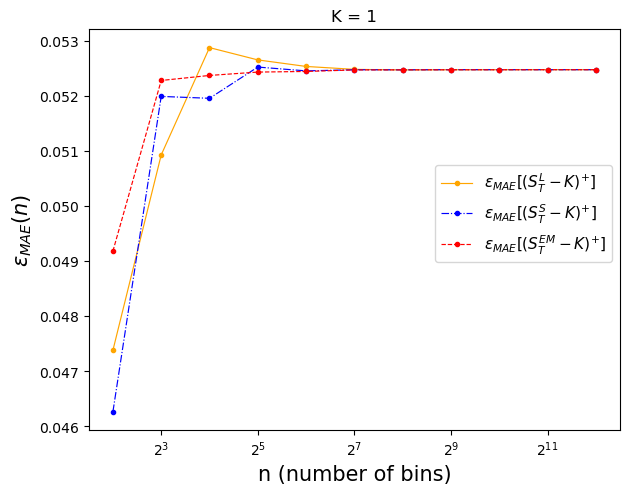

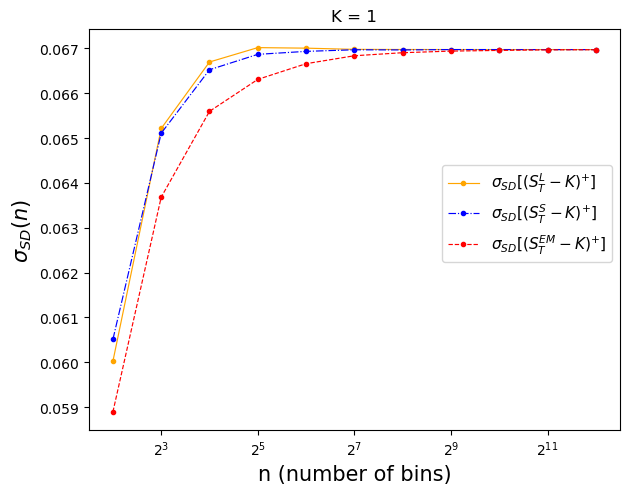

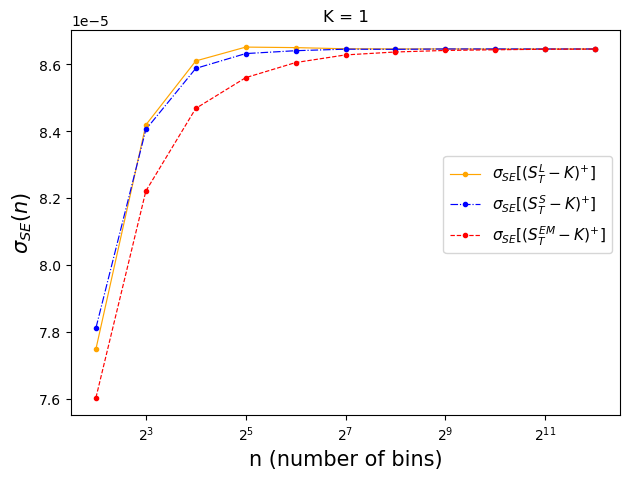

In [33]:
### Plots of mean error and standard deviation for K = 1 ###

f0 = plt.figure(1)
ax_mae=plt.axes()

ax_mae.plot(number_bins_list,mean_absolute_error_linear_counts,label=r'$\epsilon_{MAE}[(S^{L}_T - K)^{+}]$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax_mae.plot(number_bins_list,mean_absolute_error_stationary_counts,label=r'$\epsilon_{MAE}[(S^{S}_T - K)^{+}]$',marker = ".",markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashdot')
ax_mae.plot(number_bins_list,mean_absolute_error_equimass_counts,label=r'$\epsilon_{MAE}[(S^{EM}_T - K)^{+}]$',marker = ".",markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')

ax_mae.set_xlabel('n (number of bins)',fontsize=15)
ax_mae.set_ylabel(r'$\epsilon_{MAE}(n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.title("K = 1")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.4),fontsize=11)
plt.savefig('K1_mae.pdf') 


plt.show()

f1 = plt.figure(2)
ax_std=plt.axes()

ax_std.plot(number_bins_list,standard_deviation_linear_counts,label=r'$\sigma_{SD}[(S^{L}_T - K)^{+}]$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax_std.plot(number_bins_list,standard_deviation_stationary_counts,label=r'$\sigma_{SD}[(S^{S}_T - K)^{+}]$',marker = ".",markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashdot')
ax_std.plot(number_bins_list,standard_deviation_equimass_counts,label=r'$\sigma_{SD}[(S^{EM}_T - K)^{+}]$',marker = ".",markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')


ax_std.set_xlabel('n (number of bins)',fontsize=15)
ax_std.set_ylabel(r'$\sigma_{SD}(n) $',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2)
plt.title("K = 1")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.4),fontsize=11)
plt.savefig('K1_stdev.pdf')

plt.show()

f2 = plt.figure(3)
ax_ste=plt.axes()

ax_ste.plot(number_bins_list,standard_error_linear_counts,label=r'$\sigma_{SE}[(S^{L}_T - K)^{+}]$', marker = ".",markersize=6, linewidth = 0.85, color = 'orange')
ax_ste.plot(number_bins_list,standard_error_stationary_counts,label=r'$\sigma_{SE}[(S^{S}_T - K)^{+}]$',marker = ".",markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashdot')
ax_ste.plot(number_bins_list,standard_error_equimass_counts,label=r'$\sigma_{SE}[(S^{EM}_T - K)^{+}]$', marker = ".",markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')


ax_ste.set_xlabel('n (number of bins)',fontsize=15)
ax_ste.set_ylabel(r'$\sigma_{SE}(n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2)
plt.title("K = 1")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.4),fontsize=11)
plt.savefig('K1_sterr.pdf')  

plt.show()

# K = 0.5: mean absolute error, standard deviation, standard error

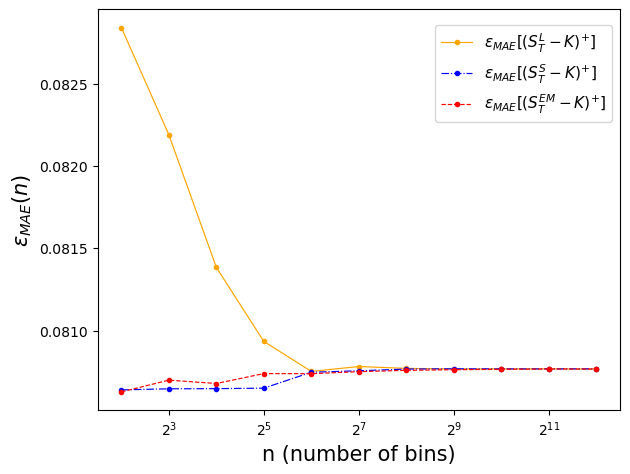

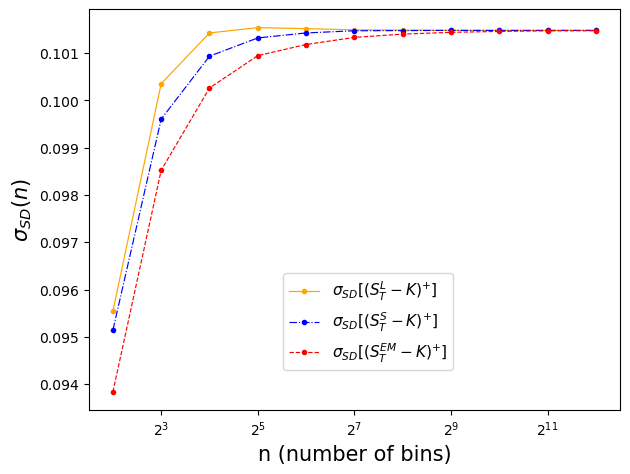

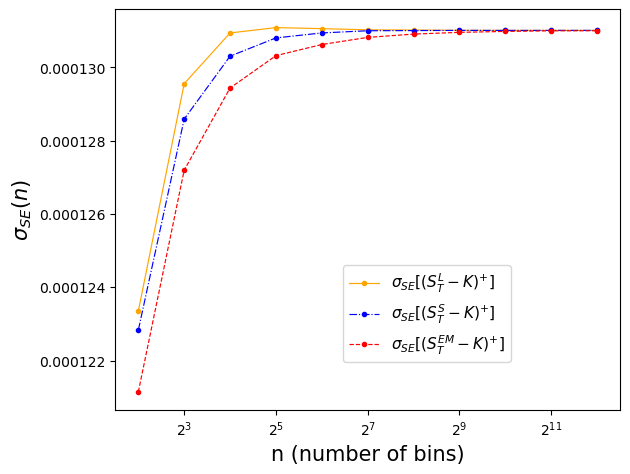

In [111]:
### Plots of mean error and standard deviation for K = 0.5 ###

f0 = plt.figure(1)
ax_mae=plt.axes()

ax_mae.plot(number_bins_list,mean_absolute_error_linear_counts,label=r'$\epsilon_{MAE}[(S^{L}_T - K)^{+}]$', marker = ".",markersize=6, linewidth = 0.85, color = 'orange')
ax_mae.plot(number_bins_list,mean_absolute_error_stationary_counts,label=r'$\epsilon_{MAE}[(S^{S}_T - K)^{+}]$', marker = ".",markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashdot')
ax_mae.plot(number_bins_list,mean_absolute_error_equimass_counts,label=r'$\epsilon_{MAE}[(S^{EM}_T - K)^{+}]$', marker = ".", markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')

ax_mae.set_xlabel('n (number of bins)',fontsize=15)
ax_mae.set_ylabel(r'$\epsilon_{MAE}(n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
#plt.title("K = 0.5")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.7),fontsize=11)
plt.savefig('K05_mae.pdf') 


plt.show()

f1 = plt.figure(2)
ax_std=plt.axes()

ax_std.plot(number_bins_list,standard_deviation_linear_counts,label=r'$\sigma_{SD}[(S^{L}_T - K)^{+}]$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax_std.plot(number_bins_list,standard_deviation_stationary_counts,label=r'$\sigma_{SD}[(S^{S}_T - K)^{+}]$', marker = ".",markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashdot')
ax_std.plot(number_bins_list,standard_deviation_equimass_counts,label=r'$\sigma_{SD}[(S^{EM}_T - K)^{+}]$',marker = ".",markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')


ax_std.set_xlabel('n (number of bins)',fontsize=15)
ax_std.set_ylabel(r'$\sigma_{SD}(n) $',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2)
#plt.title("K = 0.5")
plt.legend(loc='lower right', bbox_to_anchor=(0.7, 0.08),fontsize=11)
plt.savefig('K05_stdev.pdf')

plt.show()

f2 = plt.figure(3)
ax_ste=plt.axes()

ax_ste.plot(number_bins_list,standard_error_linear_counts,label=r'$\sigma_{SE}[(S^{L}_T - K)^{+}]$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax_ste.plot(number_bins_list,standard_error_stationary_counts,label=r'$\sigma_{SE}[(S^{S}_T - K)^{+}]$', marker = ".", markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashdot')
ax_ste.plot(number_bins_list,standard_error_equimass_counts,label=r'$\sigma_{SE}[(S^{EM}_T - K)^{+}]$',marker = ".", markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')


ax_ste.set_xlabel('n (number of bins)',fontsize=15)
ax_ste.set_ylabel(r'$\sigma_{SE}(n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2)
#plt.title("K = 0.5")
plt.legend(loc='lower right', bbox_to_anchor=(0.8, 0.1),fontsize=11)
plt.savefig('K05_sterr.pdf') 


plt.show()

# K = 1: average call price & absolute error with respect to normal distribution value

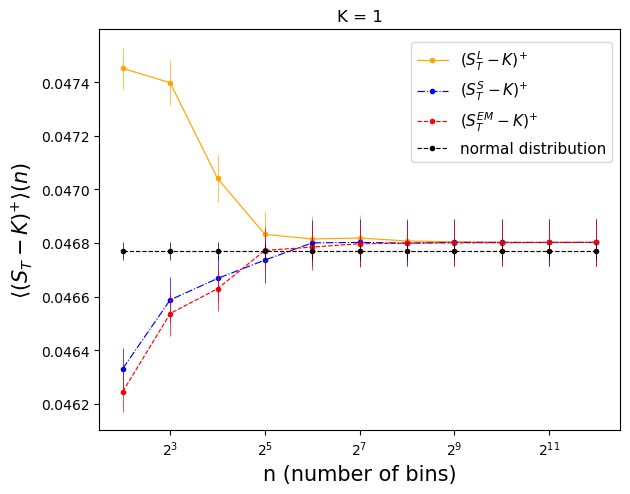

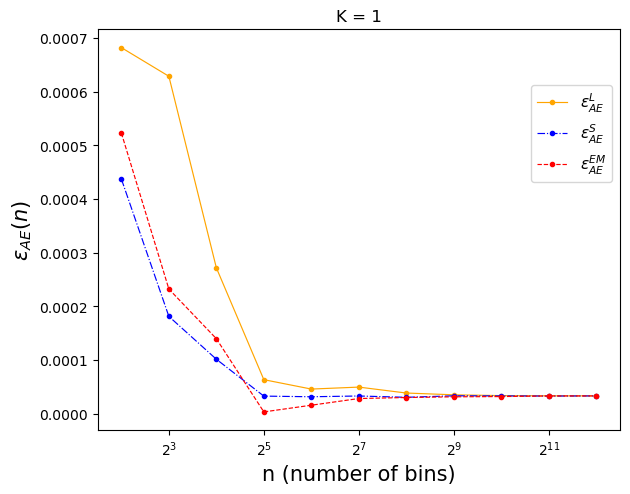

In [34]:
### K = 1 ###


f2 = plt.figure(2)
ax2=plt.axes()

ax2.plot(number_bins_list,blackscholes_linear_counts,label=r'$(S^{L}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax2.plot(number_bins_list,blackscholes_stationary_counts,label=r'$(S^{S}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'blue', linestyle='dashdot')
ax2.plot(number_bins_list,blackscholes_equimass_counts,label=r'$(S^{EM}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')
ax2.plot(number_bins_list,data_option_pricing,label='normal distribution', marker = ".", markersize=6, linewidth = 0.85, color = 'black',linestyle='dashed')

ax2.errorbar(number_bins_list, [el[0] for el in blackscholes_linear_counts],
               xerr=0,
               yerr= [el[0] for el in standard_error_linear_counts],
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'orange')

ax2.errorbar(number_bins_list, [el[0] for el in blackscholes_stationary_counts],
            xerr=0,
            yerr= [el[0] for el in standard_error_stationary_counts],
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'blue')

ax2.errorbar(number_bins_list, [el[0] for el in blackscholes_equimass_counts],
            xerr=0,
            yerr= [el[0] for el in standard_error_equimass_counts],
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'red')

ax2.errorbar(number_bins_list, data_option_pricing,
            xerr=0,
            yerr= blackscholes_theoretical_standard_error,
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'black')

ax2.set_xlabel('n (number of bins)',fontsize=15)
ax2.set_ylabel(r'$\langle (S_{T} - K)^{+}\rangle (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.title("K = 1")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.65),fontsize=11)
#plt.savefig('K1_mean.pdf')

plt.show()


f3 = plt.figure(3)
ax3 = plt.axes()

ax3.plot(number_bins_list,absolute_error_linear,label=r'$\epsilon^{L}_{AE}$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax3.plot(number_bins_list,absolute_error_stationary,label=r'$\epsilon^{S}_{AE}$', marker = ".", markersize=6, linewidth = 0.85, color = 'blue', linestyle='dashdot')
ax3.plot(number_bins_list,absolute_error_equimass,label=r'$\epsilon^{EM}_{AE}$',marker = ".", markersize=6, linewidth = 0.85, color = 'red', linestyle='dashed')

ax3.set_xlabel('n (number of bins)',fontsize=15)
ax3.set_ylabel(r'$\epsilon_{AE} (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.title("K = 1")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.6),fontsize=11)
#plt.savefig('K1_abserr.pdf')

plt.show()


# K = 0.5: average call price & absolute error with respect to normal distribution value

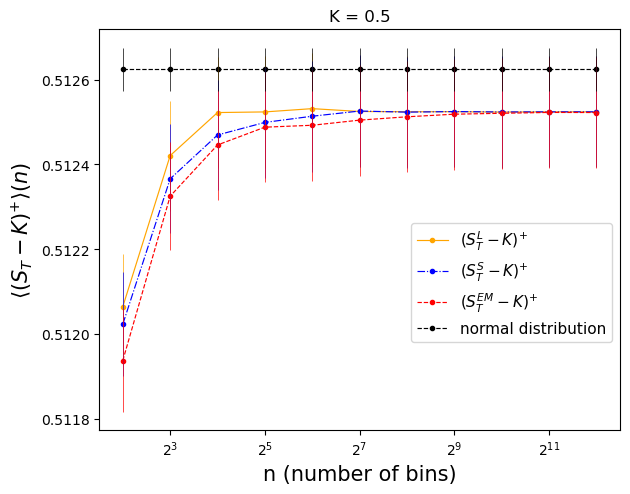

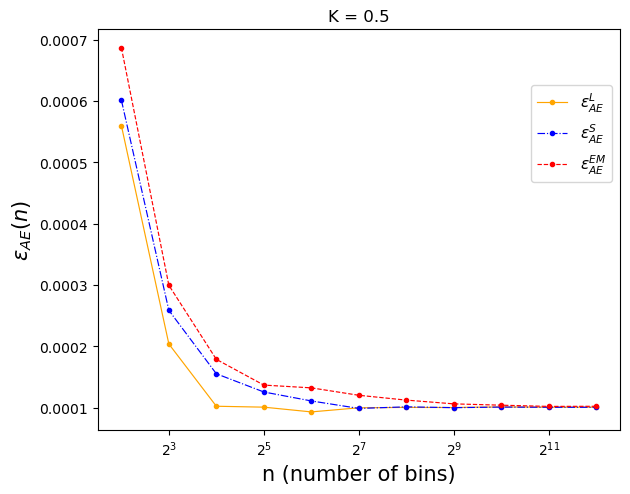

In [106]:
### K = 0.5 ###


f2 = plt.figure(2)
ax2=plt.axes()

ax2.plot(number_bins_list,blackscholes_linear_counts,label=r'$(S^{L}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax2.plot(number_bins_list,blackscholes_stationary_counts,label=r'$(S^{S}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'blue', linestyle='dashdot')
ax2.plot(number_bins_list,blackscholes_equimass_counts,label=r'$(S^{EM}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')
ax2.plot(number_bins_list,data_option_pricing,label='normal distribution', marker = ".", markersize=6, linewidth = 0.85, color = 'black',linestyle='dashed')

ax2.errorbar(number_bins_list, [el[0] for el in blackscholes_linear_counts],
               xerr=0,
               yerr= [el[0] for el in standard_error_linear_counts],
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'orange')

ax2.errorbar(number_bins_list, [el[0] for el in blackscholes_stationary_counts],
            xerr=0,
            yerr= [el[0] for el in standard_error_stationary_counts],
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'blue')

ax2.errorbar(number_bins_list, [el[0] for el in blackscholes_equimass_counts],
            xerr=0,
            yerr= [el[0] for el in standard_error_equimass_counts],
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'red')

ax2.errorbar(number_bins_list, data_option_pricing,
            xerr=0,
            yerr= blackscholes_theoretical_standard_error,
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'black')

ax2.set_xlabel('n (number of bins)',fontsize=15)
ax2.set_ylabel(r'$\langle (S_{T} - K)^{+}\rangle (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.title("K = 0.5")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.2),fontsize=11)
#plt.savefig('K05_mean.pdf')

plt.show()


f3 = plt.figure(3)
ax3 = plt.axes()

ax3.plot(number_bins_list,absolute_error_linear,label=r'$\epsilon^{L}_{AE}$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax3.plot(number_bins_list,absolute_error_stationary,label=r'$\epsilon^{S}_{AE}$', marker = ".", markersize=6, linewidth = 0.85, color = 'blue', linestyle='dashdot')
ax3.plot(number_bins_list,absolute_error_equimass,label=r'$\epsilon^{EM}_{AE}$',marker = ".", markersize=6, linewidth = 0.85, color = 'red', linestyle='dashed')

ax3.set_xlabel('n (number of bins)',fontsize=15)
ax3.set_ylabel(r'$\epsilon_{AE} (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.title("K = 0.5")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.6),fontsize=11)
#plt.savefig('K05_abserr.pdf')

plt.show()


# Probability distributions of linear, stationary and equimass call prices

In [107]:
### Numerical calculation of the probability distribution function for S_T ###

# Because in the calculation of S_T all of the parameters are constant except for the quantizers y_linear
# and y_stationary, which can take nbins possible values (knots) where nbins is the number of bins considered, 
# S_T can then take nbins possible values as well. 

# We alreay know the probabilities for the stationary quantizers, from the solution to the N-gamma equations
# It is easy to verify that for number_simulations = 30.000, from the frequency of appearance of the stationary values
# one can numerically obtain a probability distribution that converges to the analytical solution we already know.
# We then only need to numerically calculate the probability distribution for the linear quantizers.

# Lists of admitted values (finite possible outcomes) for the stockprice, for each possible number of bins

stockprice_linear_values = [[]]*len(number_bins_list)
stockprice_stationary_values = [[]]*len(number_bins_list)
stockprice_equimass_values = [[]]*len(number_bins_list)

blackscholes_linear_values = [[]]*len(number_bins_list)
blackscholes_stationary_values = [[]]*len(number_bins_list)
blackscholes_equimass_values = [[]]*len(number_bins_list)


for index_bin in range(0,len(number_bins_list)):
    
    for el in knots_linear[index_bin]:
        stockprice_linear_values[index_bin] = append(stockprice_linear_values[index_bin], stockprice_process(el))
        blackscholes_linear_values[index_bin] = append(blackscholes_linear_values[index_bin], max(stockprice_process(el)-K,0))
        
    for el2 in knots_stationary[index_bin]:
        stockprice_stationary_values[index_bin] = append(stockprice_stationary_values[index_bin], stockprice_process(el2))
        blackscholes_stationary_values[index_bin] = append(blackscholes_stationary_values[index_bin], max(stockprice_process(el2)-K,0))


    for el3 in knots_equimass[index_bin]:
        stockprice_equimass_values[index_bin] = append(stockprice_equimass_values[index_bin], stockprice_process(el3))
        blackscholes_equimass_values[index_bin] = append(blackscholes_equimass_values[index_bin], max(stockprice_process(el3)-K,0))



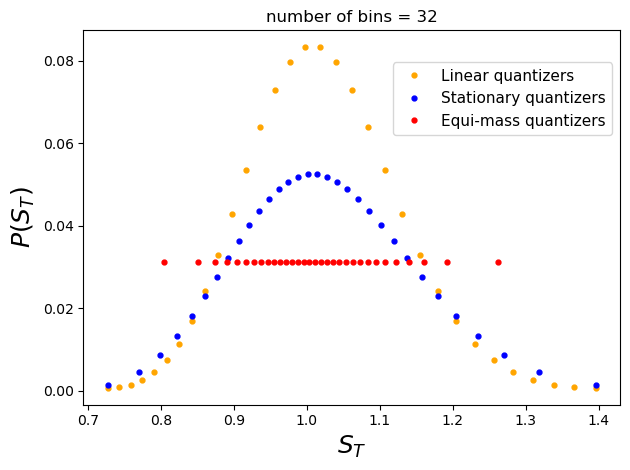

In [41]:
# Plots probability distributuon for stockprice values

# Simulations chosen: number_simulations = 60.000

bins_index_choice = 3
f1 = plt.figure(1)
ax=plt.axes()
ax.plot(stockprice_linear_values[bins_index_choice],probabilities_linear[bins_index_choice],marker = ".",label='Linear quantizers',markersize=7, linewidth = 0, color = 'orange')
ax.plot(stockprice_stationary_values[bins_index_choice],probabilities_stationary[bins_index_choice],marker = ".",label='Stationary quantizers',markersize=7, linewidth = 0, color = 'blue')
ax.plot(stockprice_equimass_values[bins_index_choice],probabilities_equimass[bins_index_choice],marker = ".",label='Equi-mass quantizers',markersize=7, linewidth = 0, color = 'red')

ax.set_xlabel(r'$S_{T}$',fontsize=18)
ax.set_ylabel(r'$P(S_{T})$',fontsize=18)
plt.title("number of bins = "+str(number_bins_list[bins_index_choice]))
plt.tight_layout()
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.7),fontsize=11)


plt.show()

# K = 1: Average values as weighted sum of probabilities * option price

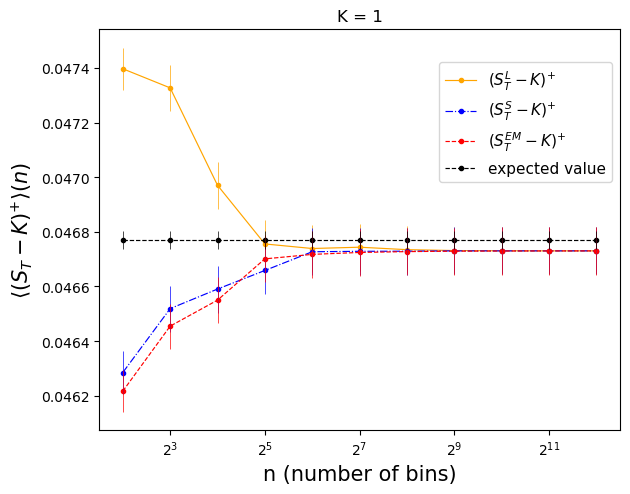

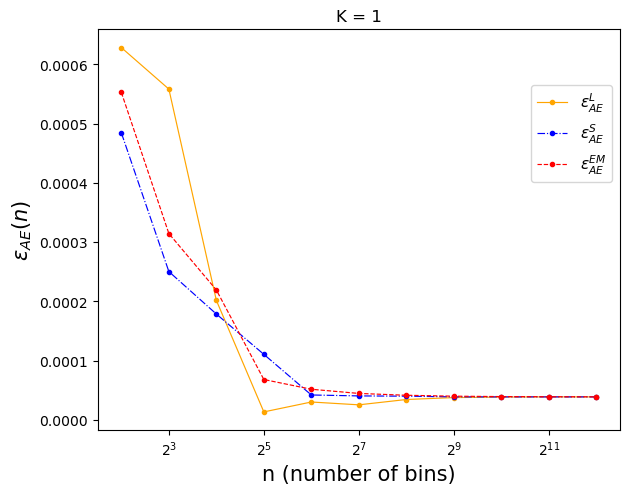

In [46]:
# Compute averages as weighted sums of the call price values
average_linear = []
average_stationary = []
average_equimass = []

error_linear = []
error_stationary = []
error_equimass = []

for index_bin in range(0,len(number_bins_list)):
    
    average_linear.append(average(blackscholes_linear_values[index_bin], weights = probabilities_linear[index_bin]))
    error_linear.append(abs(average_linear[index_bin] - blackscholes_theoretical))
    
    average_stationary.append(average(blackscholes_stationary_values[index_bin], weights = probabilities_stationary[index_bin]))
    error_stationary.append(abs(average_stationary[index_bin] - blackscholes_theoretical))

    average_equimass.append(average(blackscholes_equimass_values[index_bin], weights = probabilities_equimass[index_bin]))
    error_equimass.append(abs(average_equimass[index_bin] - blackscholes_theoretical))
        
    
f4 = plt.figure(4)
ax4=plt.axes()

ax4.plot(number_bins_list,average_linear,label=r'$(S^{L}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax4.plot(number_bins_list,average_stationary,label=r'$(S^{S}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashdot')
ax4.plot(number_bins_list,average_equimass,label=r'$(S^{EM}_T - K)^{+}$',marker = ".", markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')


ax4.plot(number_bins_list,data_option_pricing,label='expected value', marker = ".", markersize=6, linewidth = 0.85, color = 'black',linestyle='dashed')


ax4.errorbar(number_bins_list, average_linear,
               xerr=0,
               yerr= [el[0] for el in standard_error_linear_counts],
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'orange')

ax4.errorbar(number_bins_list, average_stationary,
            xerr=0,
            yerr= [el[0] for el in standard_error_stationary_counts],
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'blue')

ax4.errorbar(number_bins_list, average_equimass,
            xerr=0,
            yerr= [el[0] for el in standard_error_equimass_counts],
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'red')

ax4.errorbar(number_bins_list, data_option_pricing,
            xerr=0,
            yerr= blackscholes_theoretical_standard_error,
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'black')



ax4.set_xlabel('n (number of bins)',fontsize=15)
ax4.set_ylabel(r'$\langle (S_{T} - K)^{+}\rangle (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.title("K = 1")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.6),fontsize=11)
plt.savefig('K1_mean.pdf')

plt.show()

f5 = plt.figure(5)
ax5 = plt.axes()

ax5.plot(number_bins_list,error_linear,label=r'$\epsilon^{L}_{AE}$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax5.plot(number_bins_list,error_stationary,label=r'$\epsilon^{S}_{AE}$',marker = ".", markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashdot')
ax5.plot(number_bins_list,error_equimass,label=r'$\epsilon^{EM}_{AE}$',marker = ".", markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')

ax5.set_xlabel('n (number of bins)',fontsize=15)
ax5.set_ylabel(r'$\epsilon_{AE} (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.title("K = 1")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.6),fontsize=11)
plt.savefig('K1_abserr.pdf')

plt.show()


# K = 0.5: Average values as weighted sum of probabilities * option price

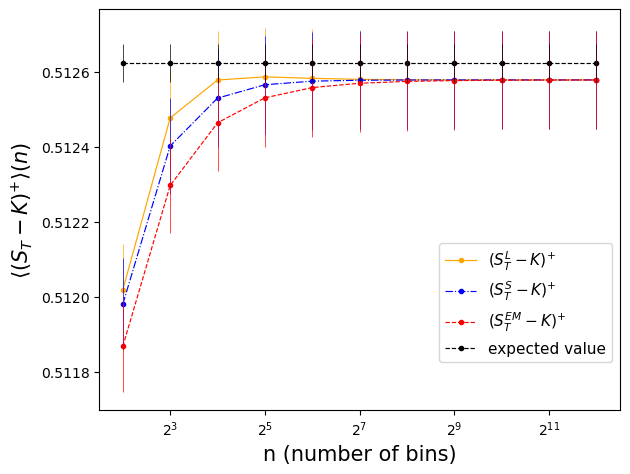

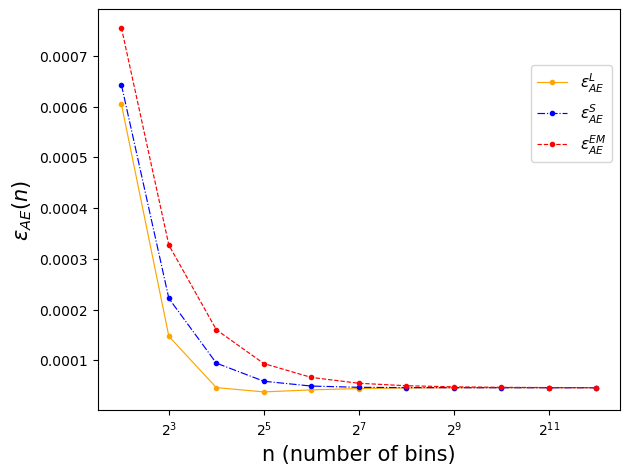

In [110]:
# Compute averages as weighted sums of the call price values
average_linear = []
average_stationary = []
average_equimass = []

error_linear = []
error_stationary = []
error_equimass = []

for index_bin in range(0,len(number_bins_list)):
    
    average_linear.append(average(blackscholes_linear_values[index_bin], weights = probabilities_linear[index_bin]))
    error_linear.append(abs(average_linear[index_bin] - blackscholes_theoretical))
    
    average_stationary.append(average(blackscholes_stationary_values[index_bin], weights = probabilities_stationary[index_bin]))
    error_stationary.append(abs(average_stationary[index_bin] - blackscholes_theoretical))

    average_equimass.append(average(blackscholes_equimass_values[index_bin], weights = probabilities_equimass[index_bin]))
    error_equimass.append(abs(average_equimass[index_bin] - blackscholes_theoretical))
        
    
f4 = plt.figure(4)
ax4=plt.axes()

ax4.plot(number_bins_list,average_linear,label=r'$(S^{L}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax4.plot(number_bins_list,average_stationary,label=r'$(S^{S}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashdot')
ax4.plot(number_bins_list,average_equimass,label=r'$(S^{EM}_T - K)^{+}$',marker = ".", markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')


ax4.plot(number_bins_list,data_option_pricing,label='expected value', marker = ".", markersize=6, linewidth = 0.85, color = 'black',linestyle='dashed')


ax4.errorbar(number_bins_list, average_linear,
               xerr=0,
               yerr= [el[0] for el in standard_error_linear_counts],
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'orange')

ax4.errorbar(number_bins_list, average_stationary,
            xerr=0,
            yerr= [el[0] for el in standard_error_stationary_counts],
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'blue')

ax4.errorbar(number_bins_list, average_equimass,
            xerr=0,
            yerr= [el[0] for el in standard_error_equimass_counts],
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'red')

ax4.errorbar(number_bins_list, data_option_pricing,
            xerr=0,
            yerr= blackscholes_theoretical_standard_error,
            fmt='none',
            elinewidth = 0.5,
            ecolor = 'black')



ax4.set_xlabel('n (number of bins)',fontsize=15)
ax4.set_ylabel(r'$\langle (S_{T} - K)^{+}\rangle (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
#plt.title("K = 0.5")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.1),fontsize=11)
plt.savefig('K05_mean.pdf')

plt.show()

f5 = plt.figure(5)
ax5 = plt.axes()

ax5.plot(number_bins_list,error_linear,label=r'$\epsilon^{L}_{AE}$', marker = ".", markersize=6, linewidth = 0.85, color = 'orange')
ax5.plot(number_bins_list,error_stationary,label=r'$\epsilon^{S}_{AE}$',marker = ".", markersize=6, linewidth = 0.85, color = 'blue',linestyle='dashdot')
ax5.plot(number_bins_list,error_equimass,label=r'$\epsilon^{EM}_{AE}$',marker = ".", markersize=6, linewidth = 0.85, color = 'red',linestyle='dashed')

ax5.set_xlabel('n (number of bins)',fontsize=15)
ax5.set_ylabel(r'$\epsilon_{AE} (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
#plt.title("K = 0.5")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.6),fontsize=11)
plt.savefig('K05_abserr.pdf')

plt.show()


# Optimal linear quantizers

In [4]:
### Optimal linear quantizers ###

# These are the solutions to Eq. 55 in Anindya's notebook; the analytical part is done with mathematica
# and here I copied the results


alpha_list = []
knots_linear_optimal = [[]]*len(number_bins_list)
cell_bounds_linear_optimal = [[]]*len(number_bins_list)
cdf_linear_optimal = [[]]*len(number_bins_list)
probabilities_linear_optimal = [[]]*len(number_bins_list)


# Solve to find alpha for optimal linear quantizer
for index_bin in range(0,len(number_bins_list)):
    
    #n = number_bins_list[index_bin]/2
    n = 1
   
    def equations_optimal_linear(alpha):
        
        def first_integral(n,j,alpha):
    
            term1 = -(exp(-(((j-1)**2)*(alpha**2))/(2*(n**2))) - exp(-((j**2)*(alpha**2))/(2*(n**2))))*(j/sqrt(2*pi))
    
            term2 = ((j**2)*alpha/(2*n))*(-erf(((j-1)*alpha)/(sqrt(2)*n)) + erf((j*alpha)/(sqrt(2)*n)))

            return term1 + term2

        def second_integral(n,alpha):
    
            term1 = -(exp(-(((n-1)**2)*(alpha**2))/(2*(n**2)))*n)/sqrt(2*pi)
    
            term2 = (1/2)*n*alpha*erfc(((n-1)*alpha)/(sqrt(2)*n))
    
            return term1 + term2

        def first_integral_sum(n,alpha):
    
            sum_index = 0
            j = 1
    
            while j < n:
                sum_index = sum_index + first_integral(n,j,alpha)
                j = j + 1
    
            return sum_index

        return first_integral_sum(n,alpha) + second_integral(n,alpha)
    
    a = fsolve(equations_optimal_linear,1)
    alpha_list.append(a)
    
    start = -a + (a/(2*n)) # for even quantizers
    h = a/n
    j = 1
    while j <= n:
        knots_linear_optimal[index_bin] = append(knots_linear_optimal[index_bin], h*(j - (1/2)))
        j= j + 1
        
    knots_linear_optimal[index_bin] = append(- knots_linear_optimal[index_bin][::-1],knots_linear_optimal[index_bin])
    
    cell_bounds_linear_optimal[index_bin] = append(cell_bounds_linear_optimal[index_bin], -inf)
    
    j = 0
    while j < 2*n - 1:
        cell_bounds_linear_optimal[index_bin] = append(cell_bounds_linear_optimal[index_bin], start + (h/2) + j*h)
        cdf_linear_optimal[index_bin] = append(cdf_linear_optimal[index_bin],norm.cdf(cell_bounds_linear_optimal[index_bin][-1]))
        j = j + 1
        
    # Last bin
    cell_bounds_linear_optimal[index_bin] = append(cell_bounds_linear_optimal[index_bin], inf)
    cdf_linear_optimal[index_bin] = append(cdf_linear_optimal[index_bin],norm.cdf(cell_bounds_linear_optimal[index_bin][-1]))




In [9]:
alpha_list[0]

array([0.79788456])

In [6]:
knots_linear_optimal[0]

array([-0.39894228,  0.39894228])

In [8]:
1/sqrt(2*pi)

0.3989422804014327

In [92]:
### Simulation of the stockprice process ###


number_simulations = 50000 # Change to set number of samples per simulation
data_option_pricing_iterations = [blackscholes_theoretical]*number_simulations

# Inizialize vectors for storing iterations

stockprice_optimal_linear_counts = []
stockprice_linear_counts = []


blackscholes_optimal_linear_counts = []
blackscholes_linear_counts = []


mean_absolute_error_optimal_linear_counts = []
mean_absolute_error_linear_counts = []


standard_deviation_optimal_linear_counts = []
standard_deviation_linear_counts = []

standard_error_optimal_linear_counts = []
standard_error_linear_counts = []


    
# For storing the results of each iteration
    
stockprice_optimal_linear_iterations = [[]]*len(number_bins_list)
stockprice_linear_iterations = [[]]*len(number_bins_list)
    
blackscholes_optimal_linear_iterations = [[]]*len(number_bins_list)
blackscholes_linear_iterations = [[]]*len(number_bins_list)
    
iterations = 0
    
while iterations < number_simulations:
        
    u = random.uniform(0,1)
    
    for index_bins in range(0,len(number_bins_list)):


        index2 = 0
    
        while cdf_linear_optimal[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_linear_optimal = knots_linear_optimal[index_bins][index2]
            
        stockprice_optimal_linear_iterations[index_bins] = append(stockprice_optimal_linear_iterations[index_bins],stockprice_process(y_linear_optimal))
            
        blackscholes_optimal_linear_iterations[index_bins] = append(blackscholes_optimal_linear_iterations[index_bins],max(stockprice_process(y_linear_optimal)-K,0))
        
            
        index2 = 0
    
        while cdf_linear_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_linear = knots_linear[index_bins][index2]
            
        stockprice_linear_iterations[index_bins] = append(stockprice_linear_iterations[index_bins],stockprice_process(y_linear))
            
        blackscholes_linear_iterations[index_bins] = append(blackscholes_linear_iterations[index_bins],max(stockprice_process(y_linear)-K,0))
            
    iterations = iterations + 1

    # End of 'while' loop for iterations
        
        
for index_bins in range(0,len(number_bins_list)):
    # Save value of mean stockprice over all #iterations = number_simulations

    mean_optimal_linear_stockprice = average(stockprice_optimal_linear_iterations[index_bins])
    mean_linear_stockprice = average(stockprice_linear_iterations[index_bins])
    
    stockprice_optimal_linear_counts.append(mean_optimal_linear_stockprice)
    stockprice_linear_counts.append(mean_linear_stockprice)

        # Save value of mean blackscholes over all #iterations = number_simulations, in order to compute standard deviation and erros over total_counts
        
    mean_optimal_linear_blackscholes = average(blackscholes_optimal_linear_iterations[index_bins])
    mean_linear_blackscholes = average(blackscholes_linear_iterations[index_bins])
        
    blackscholes_optimal_linear_counts.append(mean_optimal_linear_blackscholes)
    blackscholes_linear_counts.append(mean_linear_blackscholes)

        
        # Save value for mean error over the iterations, number_simulations
        
    mean_optimal_linear_error = mean_absolute_error(blackscholes_optimal_linear_iterations[index_bins],data_option_pricing_iterations)
    mean_linear_error = mean_absolute_error(blackscholes_linear_iterations[index_bins],data_option_pricing_iterations)

    mean_absolute_error_optimal_linear_counts.append(mean_optimal_linear_error)
    mean_absolute_error_linear_counts.append(mean_linear_error)

            # Save value for standard deviation over the iterations, number_simulations
        
    standard_deviation_optimal_linear = stdev(blackscholes_optimal_linear_iterations[index_bins])
    standard_deviation_linear = stdev(blackscholes_linear_iterations[index_bins])

        
    standard_deviation_optimal_linear_counts.append(standard_deviation_optimal_linear)
    standard_deviation_linear_counts.append(standard_deviation_linear)

        # Save value for standard deviation over the iterations, number_simulations
        
    standard_error_optimal_linear_counts.append(standard_deviation_optimal_linear/sqrt(number_simulations))
    standard_error_linear_counts.append(standard_deviation_linear/sqrt(number_simulations))

    # End of 'for' loop for bins
    

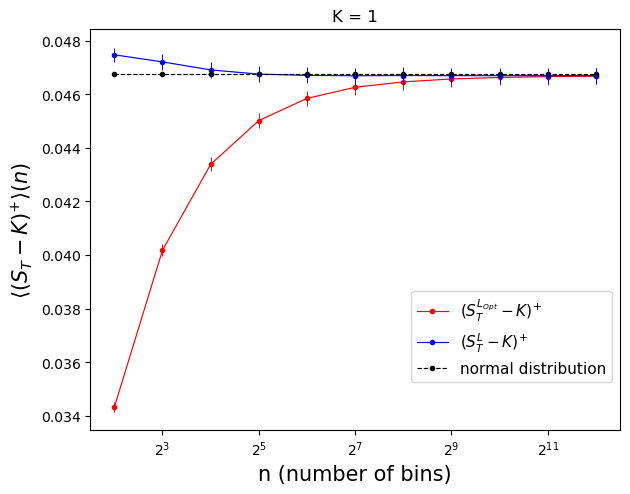

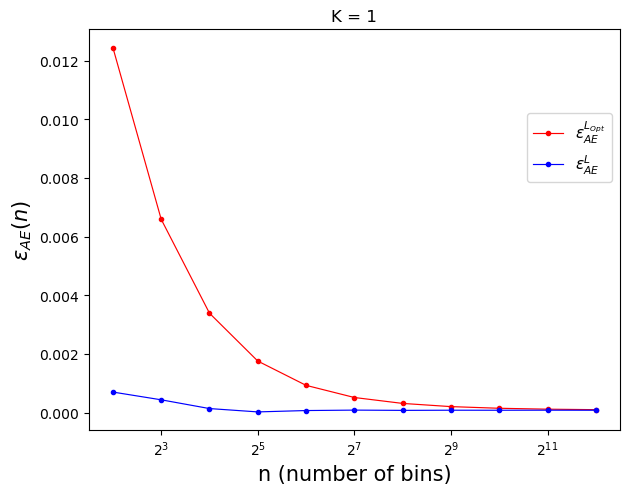

In [94]:
### K = 1 ###

absolute_error_optimal_linear = []
absolute_error_linear = []
# Absolute error

for index_bins in range(0,len(number_bins_list)):
    absolute_error_optimal_linear.append(abs(blackscholes_optimal_linear_counts[index_bins] - blackscholes_theoretical))
    absolute_error_linear.append(abs(blackscholes_linear_counts[index_bins] - blackscholes_theoretical))



f2 = plt.figure(2)
ax2=plt.axes()

ax2.plot(number_bins_list,blackscholes_optimal_linear_counts,label=r'$(S^{L_{Opt}}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'red')
ax2.plot(number_bins_list,blackscholes_linear_counts,label=r'$(S^{L}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'blue')

ax2.plot(number_bins_list,data_option_pricing,label='normal distribution', marker = ".", markersize=6, linewidth = 0.85, color = 'black',linestyle='dashed')

ax2.errorbar(number_bins_list, blackscholes_optimal_linear_counts,
               xerr=0,
               yerr= standard_error_optimal_linear_counts,
               fmt='none',
               elinewidth = 0.7,
               ecolor = 'red')

ax2.errorbar(number_bins_list, blackscholes_linear_counts,
               xerr=0,
               yerr= standard_error_linear_counts,
               fmt='none',
               elinewidth = 0.7,
               ecolor = 'blue')

ax2.errorbar(number_bins_list, data_option_pricing,
            xerr=0,
            yerr= blackscholes_theoretical_standard_error,
            fmt='none',
            elinewidth = 0.7,
            ecolor = 'black')

ax2.set_xlabel('n (number of bins)',fontsize=15)
ax2.set_ylabel(r'$\langle (S_{T} - K)^{+}\rangle (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.title("K = 1")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.1),fontsize=11)


plt.show()



f3 = plt.figure(3)
ax3 = plt.axes()

ax3.plot(number_bins_list,absolute_error_optimal_linear,label=r'$\epsilon^{L_{Opt}}_{AE}$', marker = ".", markersize =6, linewidth = 0.85, color = 'red')
ax3.plot(number_bins_list,absolute_error_linear,label=r'$\epsilon^{L}_{AE}$', marker = ".", markersize = 6, linewidth = 0.85, color = 'blue')

ax3.set_xlabel('n (number of bins)',fontsize=15)
ax3.set_ylabel(r'$\epsilon_{AE} (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.title("K = 1")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.6),fontsize=11)

plt.show()

In [ ]:
### K = 0.5 ###

absolute_error_optimal_linear = []
absolute_error_linear = []
# Absolute error

for index_bins in range(0,len(number_bins_list)):
    absolute_error_optimal_linear.append(abs(blackscholes_optimal_linear_counts[index_bins] - blackscholes_theoretical))
    absolute_error_linear.append(abs(blackscholes_linear_counts[index_bins] - blackscholes_theoretical))



f2 = plt.figure(2)
ax2=plt.axes()

ax2.plot(number_bins_list,blackscholes_optimal_linear_counts,label=r'$(S^{L_{Opt}}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'red')
ax2.plot(number_bins_list,blackscholes_linear_counts,label=r'$(S^{L}_T - K)^{+}$', marker = ".", markersize=6, linewidth = 0.85, color = 'blue')

ax2.plot(number_bins_list,data_option_pricing,label='normal distribution', marker = ".", markersize=6, linewidth = 0.85, color = 'black',linestyle='dashed')

ax2.errorbar(number_bins_list, blackscholes_optimal_linear_counts,
               xerr=0,
               yerr= standard_error_optimal_linear_counts,
               fmt='none',
               elinewidth = 0.7,
               ecolor = 'red')

ax2.errorbar(number_bins_list, blackscholes_linear_counts,
               xerr=0,
               yerr= standard_error_linear_counts,
               fmt='none',
               elinewidth = 0.7,
               ecolor = 'blue')

ax2.errorbar(number_bins_list, data_option_pricing,
            xerr=0,
            yerr= blackscholes_theoretical_standard_error,
            fmt='none',
            elinewidth = 0.7,
            ecolor = 'black')

ax2.set_xlabel('n (number of bins)',fontsize=15)
ax2.set_ylabel(r'$\langle (S_{T} - K)^{+}\rangle (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.title("K = 0.5")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.1),fontsize=11)


plt.show()



f3 = plt.figure(3)
ax3 = plt.axes()

ax3.plot(number_bins_list,absolute_error_optimal_linear,label=r'$\epsilon^{L_{Opt}}_{AE}$', marker = ".", markersize =6, linewidth = 0.85, color = 'red')
ax3.plot(number_bins_list,absolute_error_linear,label=r'$\epsilon^{L}_{AE}$', marker = ".", markersize = 6, linewidth = 0.85, color = 'blue')

ax3.set_xlabel('n (number of bins)',fontsize=15)
ax3.set_ylabel(r'$\epsilon_{AE} (n)$',fontsize=15)

plt.tight_layout()
plt.xscale('log', base=2) 
plt.title("K = 0.5")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.6),fontsize=11)

plt.show()

In [ ]:
tmp_K1_linear = standard_error_linear_counts